<p align="center">
  <img src="https://i.ytimg.com/vi/Wm8ftqDZUVk/maxresdefault.jpg" alt="FIUBA" width="25%"/>
  </p>
  
# **Trabajo Práctico 2: Críticas Cinematográficas**
### **Grupo**: 11 - Los Pandas 🐼
### **Cuatrimestre**: 2ºC 2023
### **Corrector**: Mateo Suster
### **Integrantes**:
- ### 106861 - Labollita, Francisco
- ### 102312 - Mundani Vegega, Ezequiel
- ###  97263 - Otegui, Matías Iñaki

# Ensamble de varios modelos

A partir de los modelos Random Forest, XGBoost y Bayes Naive entrenados en notebooks anteriores, se realiza un ensamble de los mismos.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
import warnings

from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, make_scorer
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.ensemble import VotingClassifier

warnings.filterwarnings('ignore', 'is_sparse is deprecated')


In [2]:
reviews = pd.read_csv('train_clean.csv')

## Entrenamiento de los modelos con los hiperparámetros óptimos

In [6]:
# Se transforma sentimiento de variable categórica a booleana
reviews['sentimiento'] = reviews['sentimiento'].replace({'positivo': 1})
reviews['sentimiento'] = reviews['sentimiento'].replace({'negativo': 0})

# Dividir los datos en conjuntos de entrenamiento y prueba
x_train, x_test, y_train, y_test = train_test_split(
    reviews['review_es'], reviews['sentimiento'], test_size=0.2, random_state=42)

# Se crea una matriz de términos de documento utilizando CountVectorizer
vectorizer = TfidfVectorizer(ngram_range = (1,2),
                             max_features= 100000)
x_train_counts = vectorizer.fit_transform(x_train)
x_test_counts = vectorizer.transform(x_test)

### Bayes Naive

In [18]:
model_bn = MultinomialNB(alpha=0.1)

model_bn.fit(x_train_counts, y_train)
y_test_pred = model_bn.predict(x_test_counts)
print("F1 score: ", f1_score(y_test, y_test_pred))

F1 score:  0.8582669420674732


### Random Forest

In [19]:
model_rf = RandomForestClassifier( 
    max_features='sqrt',
    oob_score=True,
    random_state=1,
    n_jobs=-1,
    criterion='entropy',
    min_samples_leaf=1,
    min_samples_split=10,
    n_estimators=300,
    max_depth=12,
    ccp_alpha=0.001
)

model_rf.fit(x_train_counts, y_train)
y_test_pred = model_rf.predict(x_test_counts)
print("F1 score: ", f1_score(y_test, y_test_pred))

F1 score:  0.8300161889343872


### XGBoost

In [8]:
model_xgb = xgb.XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.4,
    max_depth=6,
    n_estimators=200, 
    subsample=1,
    random_state=0,
    n_jobs=-1
)

model_xgb.fit(x_train_counts, y_train)
y_test_pred = model_xgb.predict(x_test_counts)
print("F1 score: ", f1_score(y_test, y_test_pred))

F1 score:  0.8431546737735663


## Ensamble con los 3 modelos anteriores

In [23]:
model_voting = VotingClassifier(
    estimators=[
        ('bn', model_bn),
        ('rf', model_rf),
        ('xgb', model_xgb)
    ], n_jobs=-1)

model_voting.fit(x_train_counts,y_train)
y_test_pred = model_voting.predict(x_test_counts)
print("F1 score: ", f1_score(y_test, y_test_pred))

F1 score:  0.8589494163424125


## Análisis del mejor modelo obtenido

In [24]:
# Transformar los datos de prueba y hacer predicciones
x_test_counts = vectorizer.transform(x_test)

y_train_pred = model_voting.predict(x_train_counts)
y_test_pred = model_voting.predict(x_test_counts)

Matriz de confusión de los datos de prueba


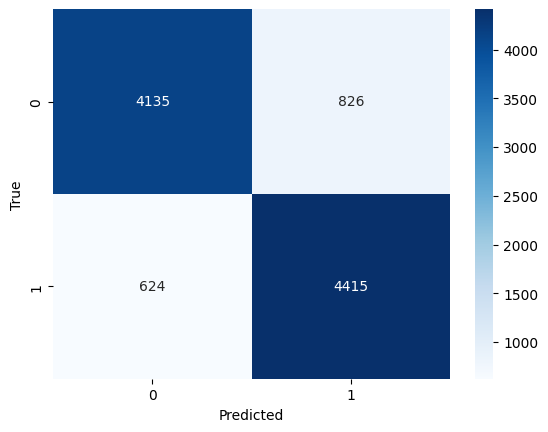

In [25]:
print("Matriz de confusión de los datos de prueba")
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True');

In [26]:
accuracy=accuracy_score(y_train, y_train_pred)
recall=recall_score(y_train, y_train_pred)
f1=f1_score(y_train, y_train_pred)
precision=precision_score(y_train, y_train_pred)

print("Cálculo de las métricas en el conjunto de entrenamiento")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_train, y_train_pred))

Cálculo de las métricas en el conjunto de entrenamiento
Accuracy:  0.931
Recall:  0.947
Precision:  0.918
F1 score:  0.932
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     20039
           1       0.92      0.95      0.93     19961

    accuracy                           0.93     40000
   macro avg       0.93      0.93      0.93     40000
weighted avg       0.93      0.93      0.93     40000



In [27]:
accuracy=accuracy_score(y_test,y_test_pred)
recall=recall_score(y_test,y_test_pred)
f1=f1_score(y_test,y_test_pred)
precision=precision_score(y_test, y_test_pred)

print("Cálculo de las métricas en el conjunto de pruebas")
print("Accuracy: ", round(accuracy, 3))
print("Recall: ", round(recall, 3))
print("Precision: ", round(precision, 3))
print("F1 score: ", round(f1, 3))

print(classification_report(y_test, y_test_pred))

Cálculo de las métricas en el conjunto de pruebas
Accuracy:  0.855
Recall:  0.876
Precision:  0.842
F1 score:  0.859
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      4961
           1       0.84      0.88      0.86      5039

    accuracy                           0.85     10000
   macro avg       0.86      0.85      0.85     10000
weighted avg       0.86      0.85      0.85     10000



## Predicción del conjunto test

In [29]:
test_df = pd.read_csv('test_clean.csv')

#Transformo todas las letras a minúscula
test_df['review_es'] = test_df['review_es'].str.lower()

x_test_counts = vectorizer.transform(test_df['review_es'])
y_pred_test = model_voting.predict(x_test_counts)

test_df['sentimiento'] = y_pred_test
test_df['sentimiento'] = test_df['sentimiento'].apply(lambda x: 'positivo' if x == 1 else 'negativo')

test_df.drop("review_es", axis=1, inplace=True)
test_df.to_csv('sample_solution.csv', index=False)